### Import das Bibliotecas

In [1]:
import os
import re
import librosa
import librosa.display

import tensorflow as tf

import time
import pandas as pd
import numpy as np
import soundfile as sf

import IPython.display as ipd1
import matplotlib.pyplot as plt

from pathlib import Path

### Definição de Constantes

In [2]:
FFT_FRAME_SIZE = 2048
HOP_LENGTH = 1024

SEG_FRAME_SIZE = 105235
OFFSET_SIZE = 10000

### Carregamento do Dataframe com os Diretórios dos Áudios

In [3]:
dsPath = '.\\Datasets\\Projeto\\'
dsInfo = pd.read_csv(dsPath+'DiretoriosEventos.csv',sep=';')  

### Remoção dos Itens ESC50 para Processamento Apenas de Itens Gunshot

In [4]:
dsInfo.drop(dsInfo[dsInfo['Diretorio'].isin(['CracklingFire','WaterDrops','GlassBreaking'])].index, inplace=True)
dsInfo

,Diretorio,Evento
0,BoltAction22,Disparo Bolt


### Carregamento dos Arquivos de Áudios e Remoção dos Zeros a Esquerda e Direita

In [5]:
count = 0
tamMaiorAudio =0
qtdArqSubDir = list()
allArqAudio = list()

print('inicio')
inicio = time.time()

for subdir in dsInfo['Diretorio']:
    dirPath = Path(dsPath+'\\AudiosOriginais\\'+subdir)
    arqObjectsPath = list(dirPath.glob('**/*.wav'))
    qtdArqSubDir.append(len(arqObjectsPath))
    
    for x in arqObjectsPath:
        count = count + 1
        audSignal, audSR = librosa.load(x, sr=44100)
        audSignal = np.trim_zeros(audSignal)
        allArqAudio.append([subdir, x, audSignal, len(audSignal)])
        
print(count)
fim = time.time()
print('fim - duração {0}'.format(fim-inicio))
    
dsInfo['QtdArq'] = qtdArqSubDir

inicio
113
fim - duração 15.998781442642212


### Conversão da Lista de Áudios em Dataframe e Gráfico Distribuição por Tamanho

<AxesSubplot:ylabel='Frequency'>

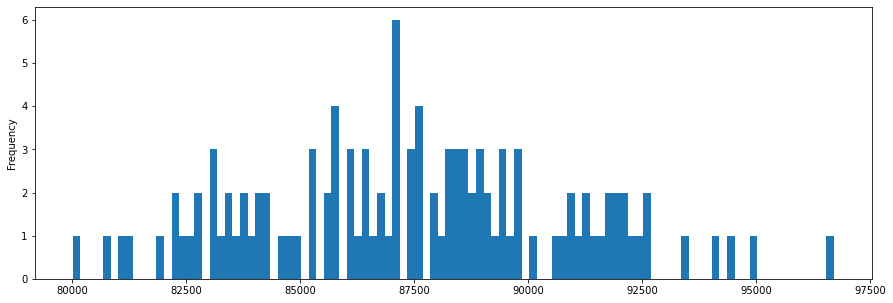

In [6]:
allArqAudioDF = pd.DataFrame(allArqAudio,columns=['diretorio','path','audio','tamanho'])
plt.figure(figsize=(15, 5))
allArqAudioDF['tamanho'].plot.hist(bins=100)

### Total de Áudios por Tipo

In [7]:
allArqAudioDF.groupby(['diretorio']).count()

,path,audio,tamanho
diretorio,,,
BoltAction22,113,113,113


### Estatísticas dos Tamanhos do Áudios

In [8]:
allArqAudioDF['tamanho'].describe()

count      113.000000
mean     87482.380531
std       3419.312870
min      80012.000000
25%      85236.000000
50%      87458.000000
75%      89681.000000
max      96697.000000
Name: tamanho, dtype: float64

### Declaração da Função de Segmentação dos Áudios

In [9]:
def audioSegmentation(audio, frameSize, offSetSize):   
    audioSplit = list()
    
    if len(audio) > frameSize:
        raise Exception('Audio maior que o segment frame size')
    elif len(audio) < frameSize:
        sizeDiff = frameSize-len(audio)
        qtdOffset = sizeDiff // offSetSize
        for x in range(qtdOffset):
            audioTemp = None
            audioTemp = np.append(np.zeros(x*offSetSize), audio)
            audioTemp = np.append(audioTemp, np.zeros(sizeDiff-(x*offSetSize)))
            audioSplit.append(audioTemp)
            
        if qtdOffset == 0:
            audioSplit.append(np.append(np.zeros(sizeDiff), audio))
            audioSplit.append(np.append(audio, np.zeros(sizeDiff)))
    else:
        audioSplit.append(audio)
    
        
    return audioSplit

### Declaração da Função Inserir os Novos Segmentos no Dataframe

In [10]:
def inserirDFSegmentos(dfAudios, segments, rate, row):
    count = 0
    nomeBase = str(row[1])[:-4]
    for seg in segments:
        count = count + 1      
        
        nome = nomeBase+'_{:04d}'.format(count)
        dfAudios.loc[len(dfAudios)] = [row[0], nome, seg, len(seg)]
        
        #plt.figure()        
        #librosa.display.waveplot(seg, sr=rate, alpha=0.5)
        #plt.show()

### Loop para Processamento da Segmentação e Montagem do Novo Dataframe

In [11]:
print('inicio')
inicio = time.time()

allArqAudioSegDF = pd.DataFrame(columns=['diretorio','nome','segmento','tamanho'])
    
for row in allArqAudioDF.values.tolist():
    audSignal = row[2]
    audSignal = np.trim_zeros(audSignal)    

    audioSegments = audioSegmentation(audSignal, SEG_FRAME_SIZE, OFFSET_SIZE)
    inserirDFSegmentos(allArqAudioSegDF, audioSegments, 44100, row)

fim = time.time()
print('fim - duração {0}'.format(fim-inicio))

inicio
fim - duração 0.33709025382995605


### Estatísticas dos Tamanhos dos Áudios do Novo Dataframe 

In [12]:
allArqAudioSegDF['tamanho'].describe()

count        142
unique         1
top       105235
freq         142
Name: tamanho, dtype: int64

### Total de Áudios por Tipo do Novo Dataframe

In [13]:
allArqAudioSegDF.groupby(['diretorio']).count()

,nome,segmento,tamanho
diretorio,,,
BoltAction22,142,142,142


### Declaração da Função Geradora do Espectrograma Mel

In [14]:
def geraSpectrograma(audioSignal, sampleRate):
    mel_spectrogram = librosa.feature.melspectrogram(audioSignal, sr=sampleRate, n_fft=FFT_FRAME_SIZE, 
                                                      hop_length=HOP_LENGTH, n_mels=10)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    return log_mel_spectrogram

### Declaração da Função que Salva o Espectrograma em Arquivo

In [15]:
def salvaSpectrograma(nomeSemExt, spectro):
    arqSpectro = str(nomeSemExt)
    arqSpectro = arqSpectro.replace('AudiosOriginais','Spectrogramas')
    arqSpectro = arqSpectro + '.npy'

    tempPath = Path(arqSpectro)
    if not tempPath.parents[0].exists():
        tempPath.parents[0].mkdir(parents=True)
    np.save(arqSpectro, spectro)      

### Declaração da Função que Salva o Novo Segmento de Áudio em Arquivo

In [16]:
def salvaAudioSegmento(nomeSemExt, segment, rate):
    arqAudio = str(nomeSemExt)
    arqAudio = arqAudio.replace('AudiosOriginais','Audios')
    arqAudio = arqAudio + '.wav'

    os.makedirs(os.path.dirname(arqAudio), exist_ok=True)
    with sf.SoundFile(arqAudio, 'w', samplerate=rate, channels=1, subtype='PCM_16') as f:
        f.write(segment)

### Loop para Gerar os Espectrogramas e Salvar em Arquivo, Assim como os Novos Segmentos

In [17]:
count = 0 

print('inicio')
inicio = time.time()

for row in allArqAudioSegDF.values.tolist():
    count = count + 1
    spectrograma = geraSpectrograma(row[2], 44100)
    salvaSpectrograma(row[1], spectrograma)
    salvaAudioSegmento(row[1], row[2], 44100)
    
fim = time.time()
print('fim - duração {0}'.format(fim-inicio))

inicio
fim - duração 1.0222322940826416
